# Local Search Progress Visualization

This notebook visualizes the progress of multiple local search runs to compare their convergence behavior.

In [9]:
l = [
  [7,8],
  [2,1],
  [6,9]
]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob

# Set up matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

## Load the Data

Load the most recent CSV file from the results directory.

In [2]:
# Find the most recent CSV file
results_dir = Path('results')
csv_files = sorted(results_dir.glob('localsearch_*.csv'))

if not csv_files:
    raise FileNotFoundError("No CSV files found in results/ directory. Run the local search first.")

latest_csv = csv_files[-1]
print(f"Loading data from: {latest_csv}")

# Load the data
df = pd.read_csv(latest_csv)
print(f"\nLoaded {len(df)} data points")
print(f"Number of runs: {df['Run'].nunique()}")
print(f"\nFirst few rows:")
df.head(10)

Loading data from: results/localsearch_20260120_035148.csv

Loaded 55 data points
Number of runs: 3

First few rows:


,Run,Step,BitsPerBase,GrammarSize,NeighborsEvaluated
0,1,-1,3.754761,13,0
1,3,-1,4.252595,16,0
2,2,-1,4.497145,17,0
3,3,0,4.127284,16,1
4,1,0,3.726546,13,3
5,2,0,4.275742,17,3
6,3,1,4.086222,16,3
7,2,1,4.203965,16,1
8,2,2,4.007255,16,1
9,3,2,3.756405,16,2


## Data Summary

Show summary statistics for each run.

In [3]:
# Summary statistics per run
summary = df.groupby('Run').agg({
    'Step': 'max',
    'BitsPerBase': ['min', 'max'],
    'GrammarSize': ['min', 'max'],
    'NeighborsEvaluated': 'sum'
}).round(4)

summary.columns = ['MaxStep', 'MinBitsPerBase', 'MaxBitsPerBase', 
                   'MinGrammarSize', 'MaxGrammarSize', 'TotalNeighborsEvaluated']
summary

,MaxStep,MinBitsPerBase,MaxBitsPerBase,MinGrammarSize,MaxGrammarSize,TotalNeighborsEvaluated
Run,,,,,,
1,9,3.2505,3.7548,9,13,125
2,17,2.8730,4.4971,8,17,185
3,23,2.8807,4.2526,6,16,206


## Visualization 1: Bits Per Base Over Steps (Main Comparison)

Compare how the loss (bits per base) decreases across different runs.

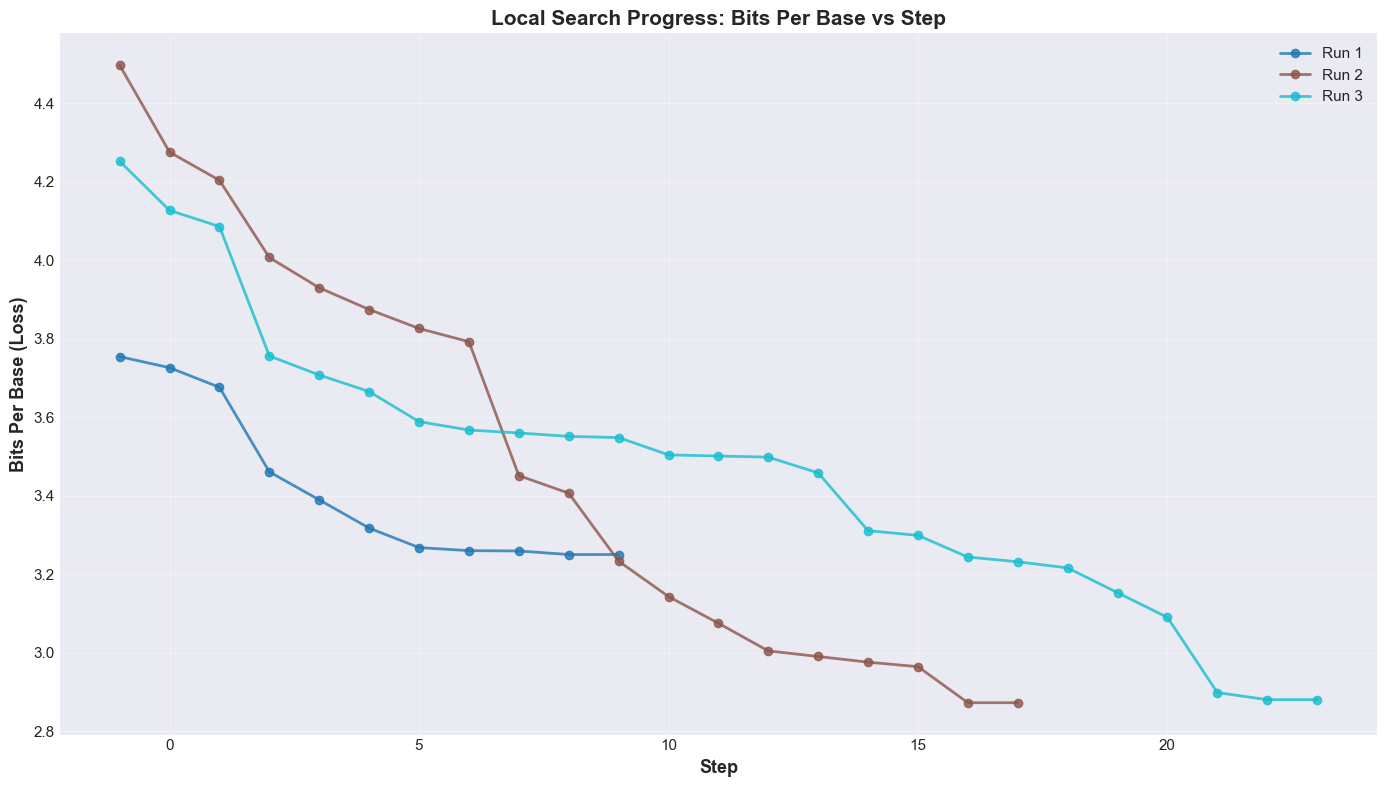


Best run: Run 2 with final bits/base = 2.8730


In [4]:
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each run with a different color
colors = plt.cm.tab10(np.linspace(0, 1, df['Run'].nunique()))

for idx, run in enumerate(sorted(df['Run'].unique())):
    run_data = df[df['Run'] == run].sort_values('Step')
    ax.plot(run_data['Step'], run_data['BitsPerBase'], 
            marker='o', linewidth=2, markersize=6,
            color=colors[idx], label=f'Run {run}', alpha=0.8)

ax.set_xlabel('Step', fontsize=13, fontweight='bold')
ax.set_ylabel('Bits Per Base (Loss)', fontsize=13, fontweight='bold')
ax.set_title('Local Search Progress: Bits Per Base vs Step', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find the best run (lowest final bits per base)
final_scores = df.groupby('Run')['BitsPerBase'].last()
best_run = final_scores.idxmin()
best_score = final_scores.min()
print(f"\nBest run: Run {best_run} with final bits/base = {best_score:.4f}")

## Visualization 2: Grammar Size Over Steps

Track how grammar size changes during optimization.

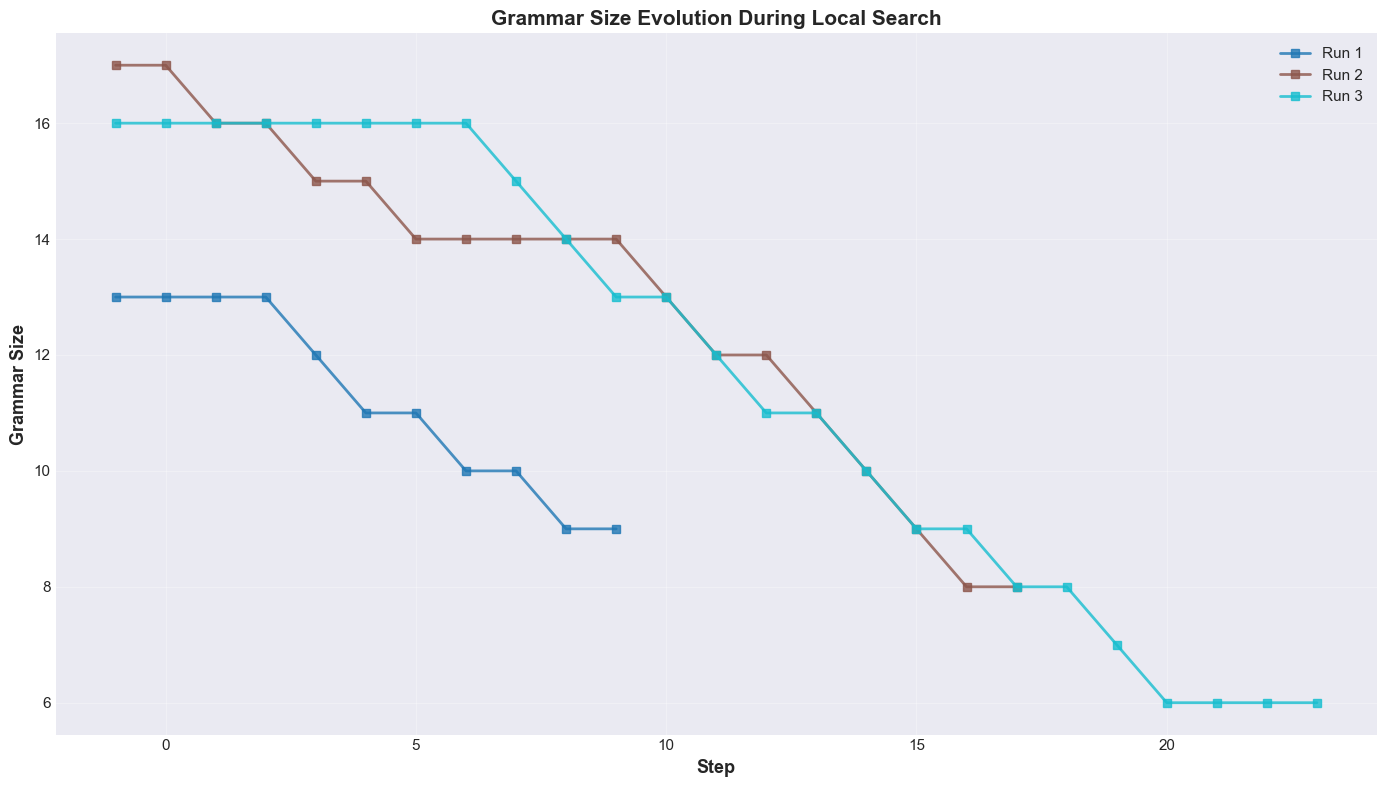

In [5]:
fig, ax = plt.subplots(figsize=(14, 8))

for idx, run in enumerate(sorted(df['Run'].unique())):
    run_data = df[df['Run'] == run].sort_values('Step')
    ax.plot(run_data['Step'], run_data['GrammarSize'], 
            marker='s', linewidth=2, markersize=6,
            color=colors[idx], label=f'Run {run}', alpha=0.8)

ax.set_xlabel('Step', fontsize=13, fontweight='bold')
ax.set_ylabel('Grammar Size', fontsize=13, fontweight='bold')
ax.set_title('Grammar Size Evolution During Local Search', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualization 3: Improvement Rate Comparison

Show the relative improvement from the initial seed for each run.

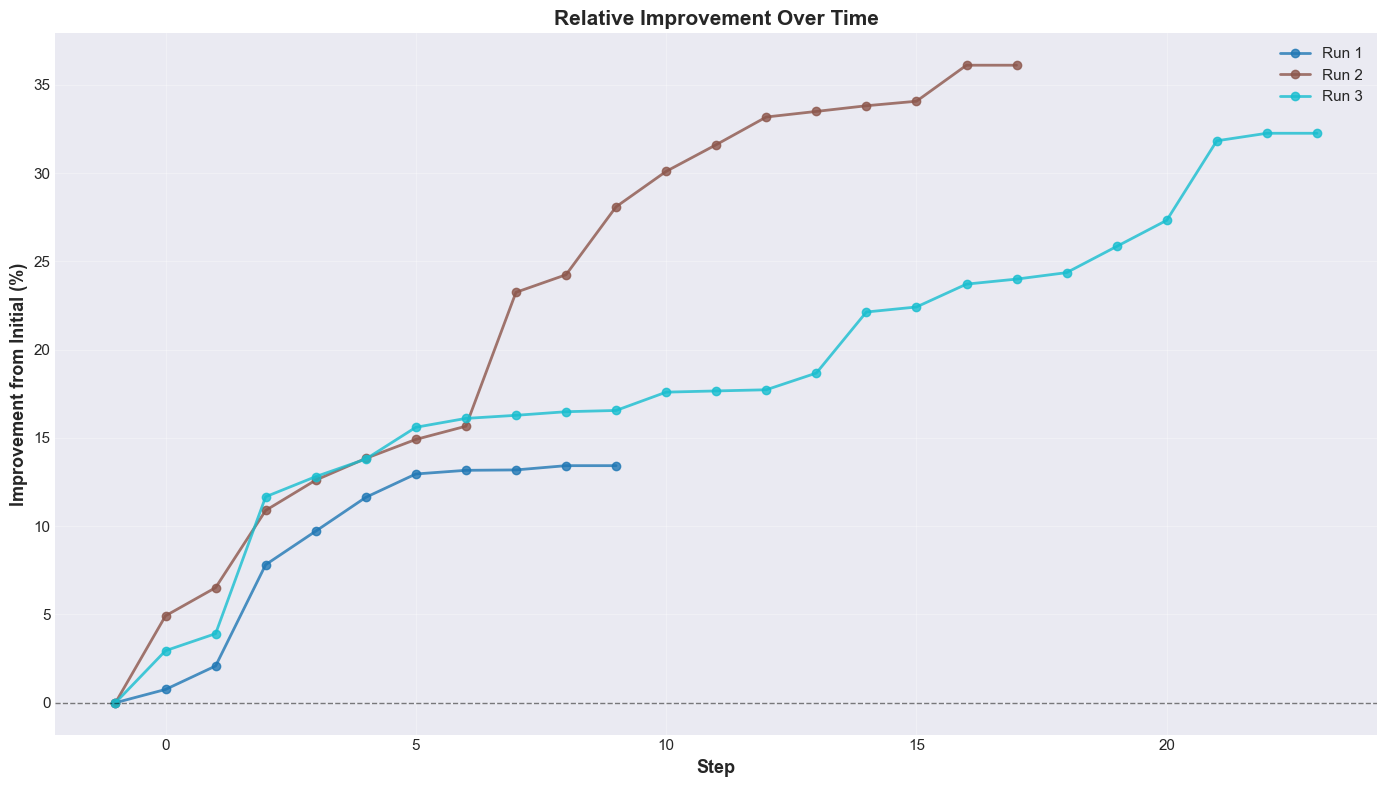

In [6]:
fig, ax = plt.subplots(figsize=(14, 8))

for idx, run in enumerate(sorted(df['Run'].unique())):
    run_data = df[df['Run'] == run].sort_values('Step')
    
    # Calculate improvement percentage from initial value
    initial_bits = run_data.iloc[0]['BitsPerBase']
    improvement_pct = ((initial_bits - run_data['BitsPerBase']) / initial_bits) * 100
    
    ax.plot(run_data['Step'], improvement_pct, 
            marker='o', linewidth=2, markersize=6,
            color=colors[idx], label=f'Run {run}', alpha=0.8)

ax.set_xlabel('Step', fontsize=13, fontweight='bold')
ax.set_ylabel('Improvement from Initial (%)', fontsize=13, fontweight='bold')
ax.set_title('Relative Improvement Over Time', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

## Visualization 4: Neighbors Evaluated

Visualize the search effort (neighbors evaluated) at each step.

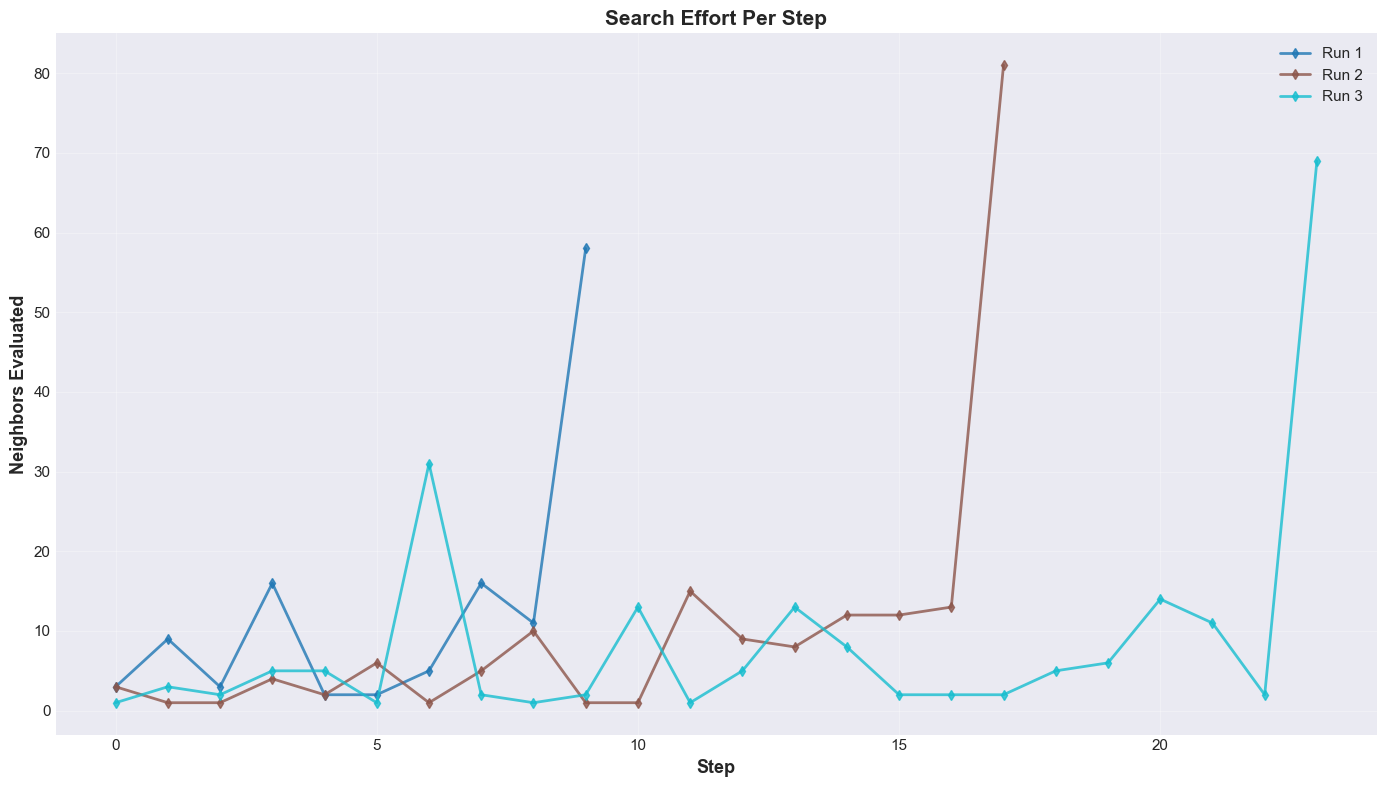

In [7]:
fig, ax = plt.subplots(figsize=(14, 8))

for idx, run in enumerate(sorted(df['Run'].unique())):
    run_data = df[df['Run'] == run].sort_values('Step')
    # Only plot steps > -1 (exclude seed)
    run_data_steps = run_data[run_data['Step'] >= 0]
    
    if len(run_data_steps) > 0:
        ax.plot(run_data_steps['Step'], run_data_steps['NeighborsEvaluated'], 
                marker='d', linewidth=2, markersize=5,
                color=colors[idx], label=f'Run {run}', alpha=0.8)

ax.set_xlabel('Step', fontsize=13, fontweight='bold')
ax.set_ylabel('Neighbors Evaluated', fontsize=13, fontweight='bold')
ax.set_title('Search Effort Per Step', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualization 5: Combined View

Show bits per base and grammar size in the same plot with dual y-axes.

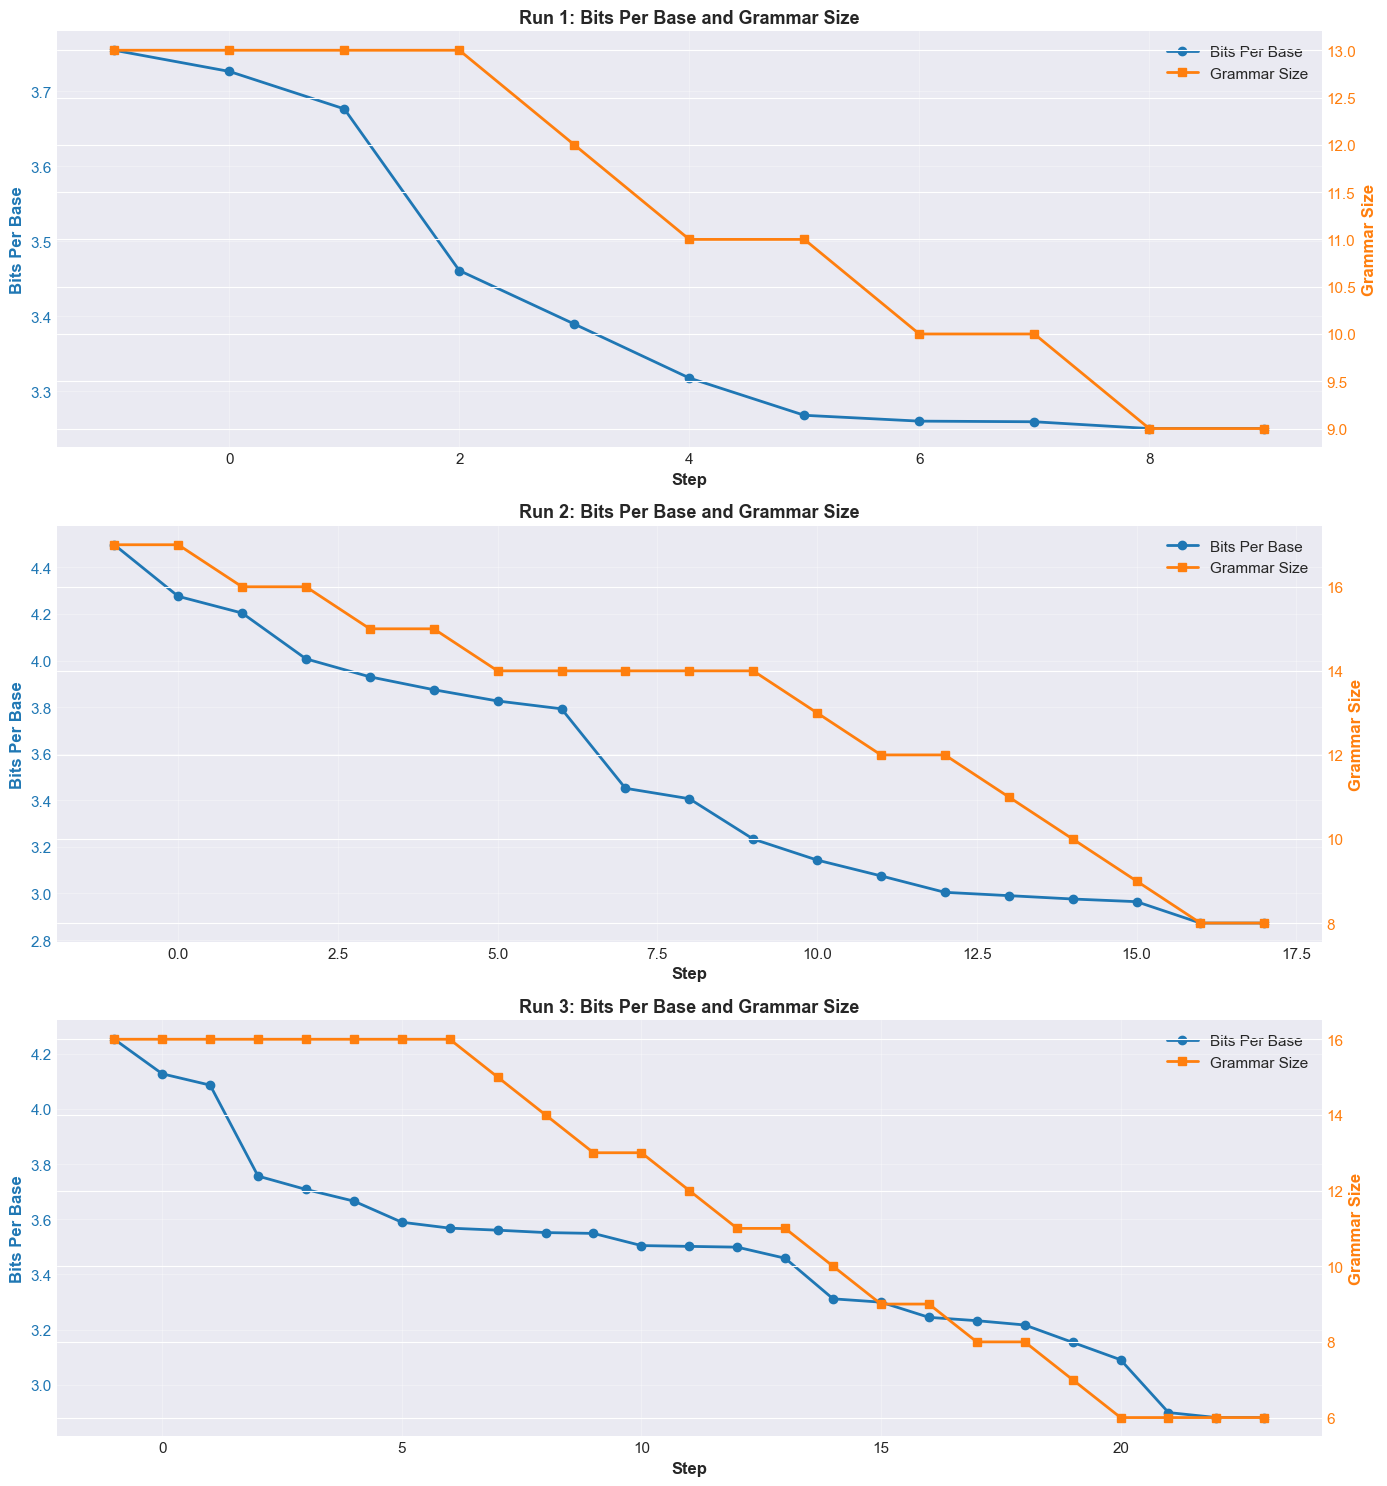

In [8]:
# Create a plot for each run
num_runs = df['Run'].nunique()
fig, axes = plt.subplots(num_runs, 1, figsize=(14, 5*num_runs))

if num_runs == 1:
    axes = [axes]

for idx, run in enumerate(sorted(df['Run'].unique())):
    run_data = df[df['Run'] == run].sort_values('Step')
    
    ax1 = axes[idx]
    color1 = 'tab:blue'
    ax1.set_xlabel('Step', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Bits Per Base', color=color1, fontsize=12, fontweight='bold')
    line1 = ax1.plot(run_data['Step'], run_data['BitsPerBase'], 
                     marker='o', linewidth=2, markersize=6,
                     color=color1, label='Bits Per Base')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel('Grammar Size', color=color2, fontsize=12, fontweight='bold')
    line2 = ax2.plot(run_data['Step'], run_data['GrammarSize'], 
                     marker='s', linewidth=2, markersize=6,
                     color=color2, label='Grammar Size')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    ax1.set_title(f'Run {run}: Bits Per Base and Grammar Size', 
                  fontsize=13, fontweight='bold')
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()